# Subgraph Localization

**Author**: Amit Boyarski & Dani Kogan

## Intro




In [60]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from subgraph_matching_via_nn.subgraph_localization_algs.gradient_descent import \
    nn_subgraph_localization
from subgraph_matching_via_nn.graph_metric_nn.graph_matric_nn import GraphMetricNetwork
from subgraph_matching_via_nn.composite_nn.compiste_nn import CompositeNeuralNetwork
from subgraph_matching_via_nn.mask_gen_networks.mask_gen_networks import \
    NNMaskGeneratorNetwork, IdentityMaskGenerator, GCNNodeClassifier
from subgraph_matching_via_nn.utils.utils import uniform_dist, DTYPE
from subgraph_matching_via_nn.graph_embedding_networks.graph_embedding_nn import \
    MomentEmbeddingNetwork
import torch
from subgraph_matching_via_nn.utils.utils import plot_degree_distribution, \
    plot_graph_with_colors
from subgraph_matching_via_nn.utils.utils import plot_indicator
from torch import tensor
import kmeans1d

plt.rcParams["figure.figsize"] = (6, 3)  # Set the desired figure size (width, height)

In [61]:

# Set the size of the graph and the subgraph
n = 30  # Number of nodes in the graph
m = 10  # Number of nodes in the subgraph
seed = 10

# Generate a random adjacency matrix A
A_upper = np.triu(np.random.randint(0, 2, size=(n, n)), k=1)
A = A_upper + A_upper.T

# Set diagonal elements to zero to remove self-loops
np.fill_diagonal(A, 0)

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(A)

# Generate a random subset of nodes for the subgraph
subgraph_nodes = np.random.choice(G.nodes(), size=m, replace=False)

# Create the subgraph by keeping only the edges that connect the selected subset of nodes
G_sub = G.subgraph(subgraph_nodes)

In [62]:
# generate the adjacency matrices
circuit_adj_matrix = np.zeros((16, 16))
circuit_edges = [(0, 1), (5, 10), (10, 11), (0, 2), (0, 3), (0, 4), (1, 5), (2, 6),
                 (6, 12), (6, 13), (6, 14), (6, 15),
                 (6, 7), (4, 8), (8, 9), (0, 6)]
subcircuit_adj_matrix = np.zeros((16, 16))
subcircuit_edges = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 5), (2, 6), (4, 8)]

# Create the graph from the adjacency matrices
G = nx.from_edgelist(circuit_edges)
G_sub = G.edge_subgraph(subcircuit_edges)

A = nx.to_numpy_array(G)
# make sure all full graph edges for each node in the subgraph appear as the subgraph edges as well

# edges_to_add = align_subgraph_edges_with_full_graph_edges(G_sub, G)
# G_sub = G.edge_subgraph(subcircuit_edges + edges_to_add)
n = len(G.nodes())
m = len(G_sub.nodes())


In [63]:
# import pickle
#
# def remove_isolated_nodes_from_graph(graph):
#     isolated_nodes_indices = list(nx.isolates(graph))
#     graph.remove_nodes_from(isolated_nodes_indices)
#
# g_full_path = '/Users/amitboy/PycharmProjects/GraphMatching/data/subcircuits/examples/comp2_32.gpickle'
# g_sub_path = '/Users/amitboy/PycharmProjects/GraphMatching/data/subcircuits/examples/comp2_32_a_subcircuit.gpickle'
#
# G = pickle.load(open(g_full_path, 'rb'))
# G_sub = pickle.load(open(g_sub_path, 'rb'))
#
# #remove_isolated_nodes_from_graph(G_sub)
#
# A = nx.to_numpy_array(G)
# n = len(G.nodes())
# m = len(G_sub.nodes())

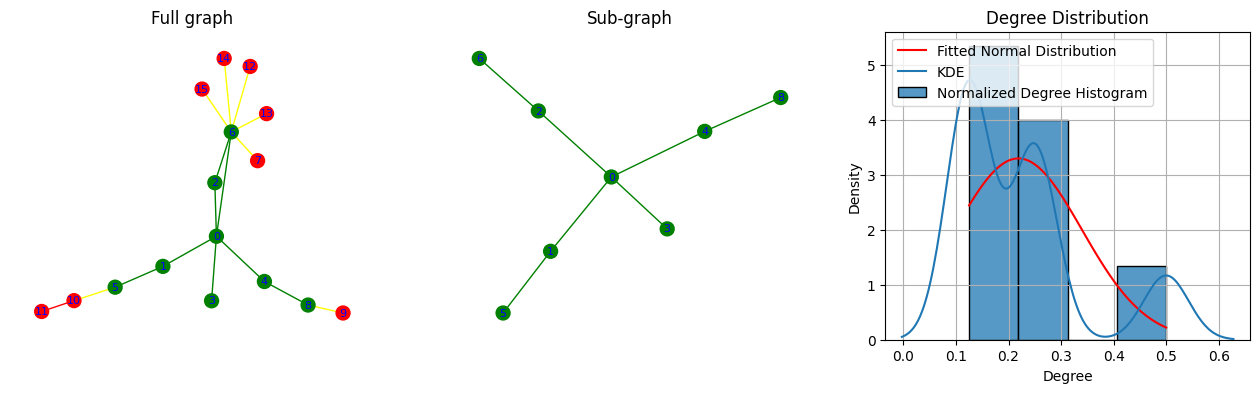

First 4 moments: ['0.2188', '0.0625', '0.0225', '0.0094']


In [64]:

# Set the indices corresponding to the subgraph nodes to 1
subgraph_node_indices = [list(G.nodes()).index(node) for node in G_sub.nodes()]
#subgraph_node_indices = list(G_sub.nodes())
w_indicator = np.zeros(len(G.nodes()))
w_indicator[subgraph_node_indices] = 1.0

# Call the function to plot the graph with colors
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_graph_with_colors(G, G_sub=None, w=w_indicator, ax=axes[0], colorbar=False,
                       title='Full graph', seed=seed, draw_labels=True)
plot_graph_with_colors(G_sub, G_sub, w=None, ax=axes[1], colorbar=False,
                       title='Sub-graph', seed=seed, draw_labels=True)
# Plot degree distribution and compute first 4 moments
n_moments = 4
moments = plot_degree_distribution(G_sub, n_moments=n_moments, ax=axes[2])
plt.show()
print(f"First 4 moments: {[f'{value:.4f}' for value in moments]}")

In [65]:

# --------- split -----------
# Assuming you have your graph G and subgraph G_sub defined
w_gt = (tensor(w_indicator)[:, None].float() / tensor(w_indicator).sum()).type(DTYPE)
A_full = torch.tensor(A).type(DTYPE)
A_sub = torch.from_numpy((nx.adjacency_matrix(G_sub)).toarray()).type(DTYPE)
params = {}
params["maxiter"] = 1000
params["lr"] = 0.0002
params["n_moments"] = 6
params["m"] = m
params["reg_param"] = 0.02  # reg param
params["k_update_plot"] = 250
#d = EmbeddingNetwork.compute_standardized_moments(w_gt, A_tensor, params["n_moments"]).type(DTYPE)
# Example usage
input_dim = n  # Input feature dimension
hidden_dim = 50  # Hidden dimension
output_dim = n
mask_generator_nn = NNMaskGeneratorNetwork(input_dim=input_dim,
                                           hidden_dim=hidden_dim,
                                           output_dim=output_dim,
                                           learnable_sigmoid=False,
                                           default_sigmoid_param_value=1.0)
# mask_generator_nn = IdentityMaskGenerator(input_dim=input_dim,
#                                           learnable_sigmoid=True,
#                                           default_value_sigmoid_param=20)
# mask_generator_nn = GCNNodeClassifier(input_dim=1,
#                                       hidden_dim=hidden_dim,
#                                       num_classes=1,
#                                       learnable_sigmoid=True,
#                                       default_value_sigmoid_param=1)
loss_fun = torch.nn.MSELoss()
embedding_nn = MomentEmbeddingNetwork(n_moments=params["n_moments"],
                                      moments_type="central")
composite_nn = CompositeNeuralNetwork(mask_gen_network=mask_generator_nn,
                                      embedding_network=embedding_nn)

embedding_sub = embedding_nn(A=A_sub.detach().type(DTYPE),
                             w=uniform_dist(A_sub.shape[0]).detach())
params["embedding_gt"] = embedding_sub
graph_metric_nn = GraphMetricNetwork(loss_fun=loss_fun, embedding_sub=embedding_sub)
w_all = []

# --------- split here-----------


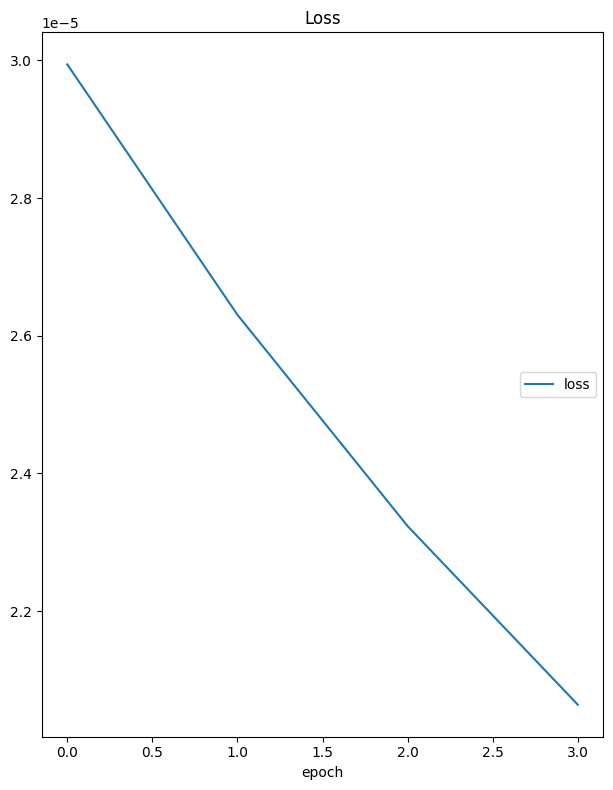

Loss
	loss             	 (min:    0.000, max:    0.000, cur:    0.000)
9


In [66]:
# Initialize the parameters
#x0 = w_gt.clone() + 0.01*torch.rand(w_gt.shape, dtype=DTYPE)
#composite_nn.mask_gen_network.init_params(default_weights=x0.detach())
num_rand_exp = 10
plt.figure(figsize=(3, 2))
for k in range(num_rand_exp):
    # TODO: how do I initialize all network params?
    # params["x0"] = x0
    # params["x0"] = x0 / torch.sum(x0)
    #params["x0"] = w_gt.T
    #composite_nn.init_params()
    nn_subgraph_localization(A=A_full,
                             subgraph_embedding_nn=composite_nn,
                             graph_metric_nn=graph_metric_nn,
                             params=params,
                             )
    opt_mask = mask_generator_nn.forward(A_full).detach()
    w_star = opt_mask.numpy()
    w_all.append(w_star)
    print(k)


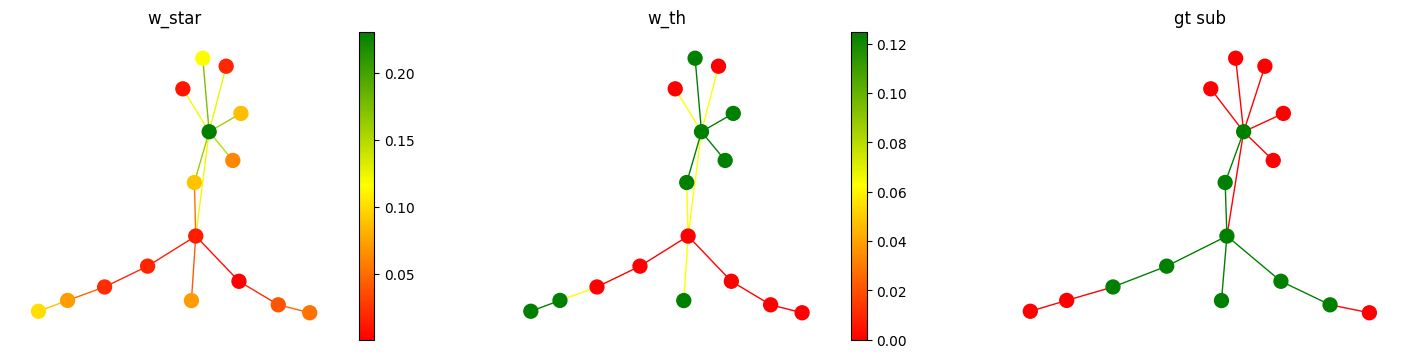

gt moments: ['0.2188', '0.0625', '0.0225', '0.0094', '0.0043', '0.0020']
est moments: ['0.2091', '0.0609', '0.0201', '0.0071', '0.0026', '0.0010']
est moments_th: ['0.1562', '0.0430', '0.0171', '0.0080', '0.0039', '0.0020']
loss = 1.844445704922944e-05


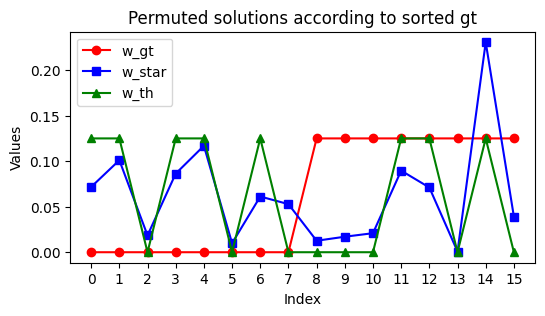

In [67]:
#mask_generator_nn.init_params(default_weights=w_gt.clone().detach(), default_sigmoid_param=torch.tensor([20]))
opt_mask = mask_generator_nn.forward(A_full).detach()
w_star = opt_mask.numpy()
#w_th, centroids = kmeans1d.cluster(w_star, k=2)
indices = np.argsort(w_star, axis=0)[-m:]  # top m
w_th = np.zeros_like(w_star, dtype=np.float64)
w_th[indices] = 1
#w_th = (w_star>np.quantile(w_star, (n-m)/n))
#w_th = np.array(w_th, dtype=np.float64)
w_th = w_th / w_th.sum()
w_bootstrap = np.array(w_all).mean()
w_bootstrap = w_bootstrap / w_bootstrap.sum()

est_moments = embedding_nn(w=tensor(w_star, requires_grad=False),
                           A=A_full.detach()).type(DTYPE)
est_moments_th = embedding_nn(w=tensor(w_th, requires_grad=False),
                              A=A_full).type(DTYPE)

fig, axes = plt.subplots(1, 3, figsize=[18, 4])
plot_graph_with_colors(G, G_sub, w_star, title='w_star', ax=axes[0], seed=seed)
plot_graph_with_colors(G, G_sub, w_th, title='w_th', ax=axes[1], seed=seed)
plot_graph_with_colors(G, G_sub, w=None, title='gt sub', ax=axes[2], seed=seed)
plt.show()

print(f"gt moments: {[f'{value:.4f}' for value in params['embedding_gt']]}")
print(f"est moments: {[f'{value:.4f}' for value in est_moments]}")
print(f"est moments_th: {[f'{value:.4f}' for value in est_moments_th]}")

embedding, _ = composite_nn(A_full)
loss = graph_metric_nn(embedding, params['embedding_gt'])
print(f"loss = {loss}")

plot_indicator([w_gt.numpy(), w_star, w_th], ['w_gt', 'w_star', 'w_th'])